🔁 Colonne 'Time' reconstruite (intervalle de 5ms entre chaque point).
📌 Temps disponible : 0.00s à 291.89s
✅ Données chargées entre 0s et 10s

🔍 Traitement du signal : BP


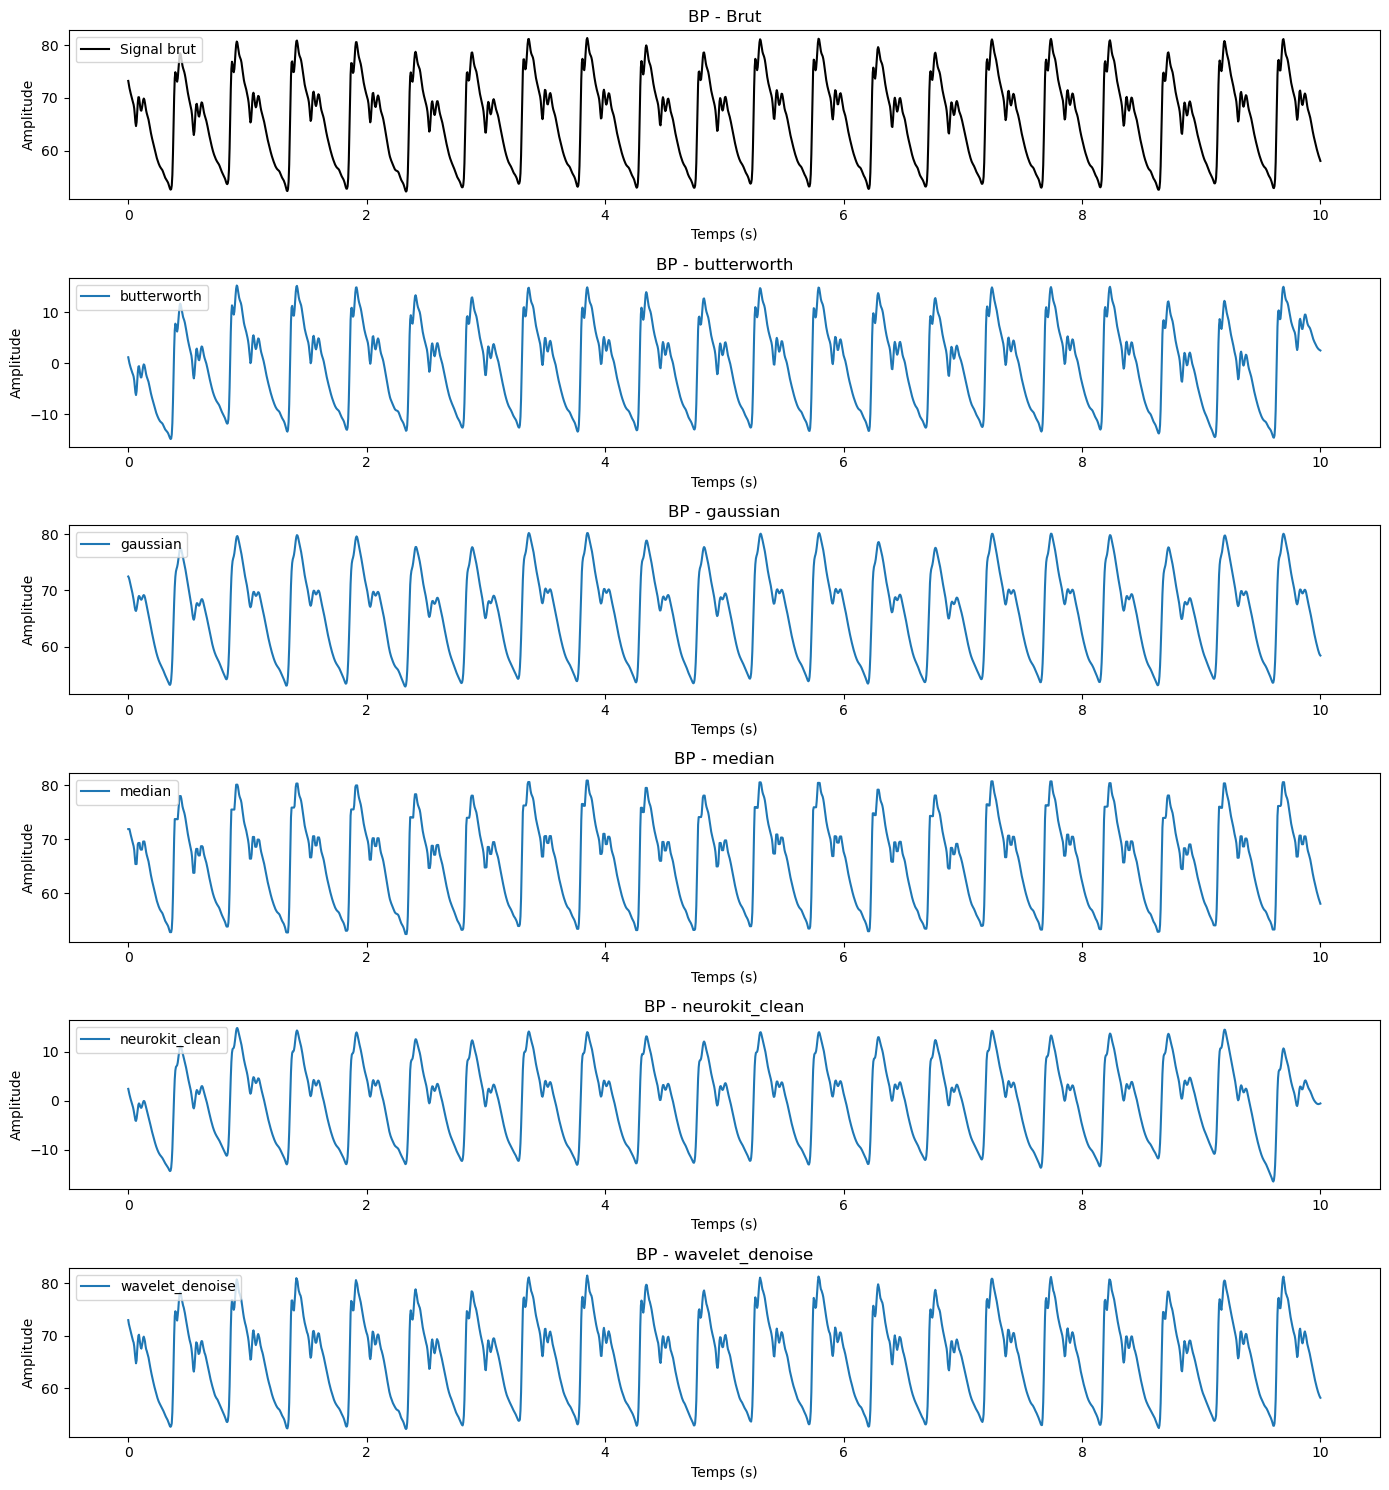


🔍 Traitement du signal : Av BP


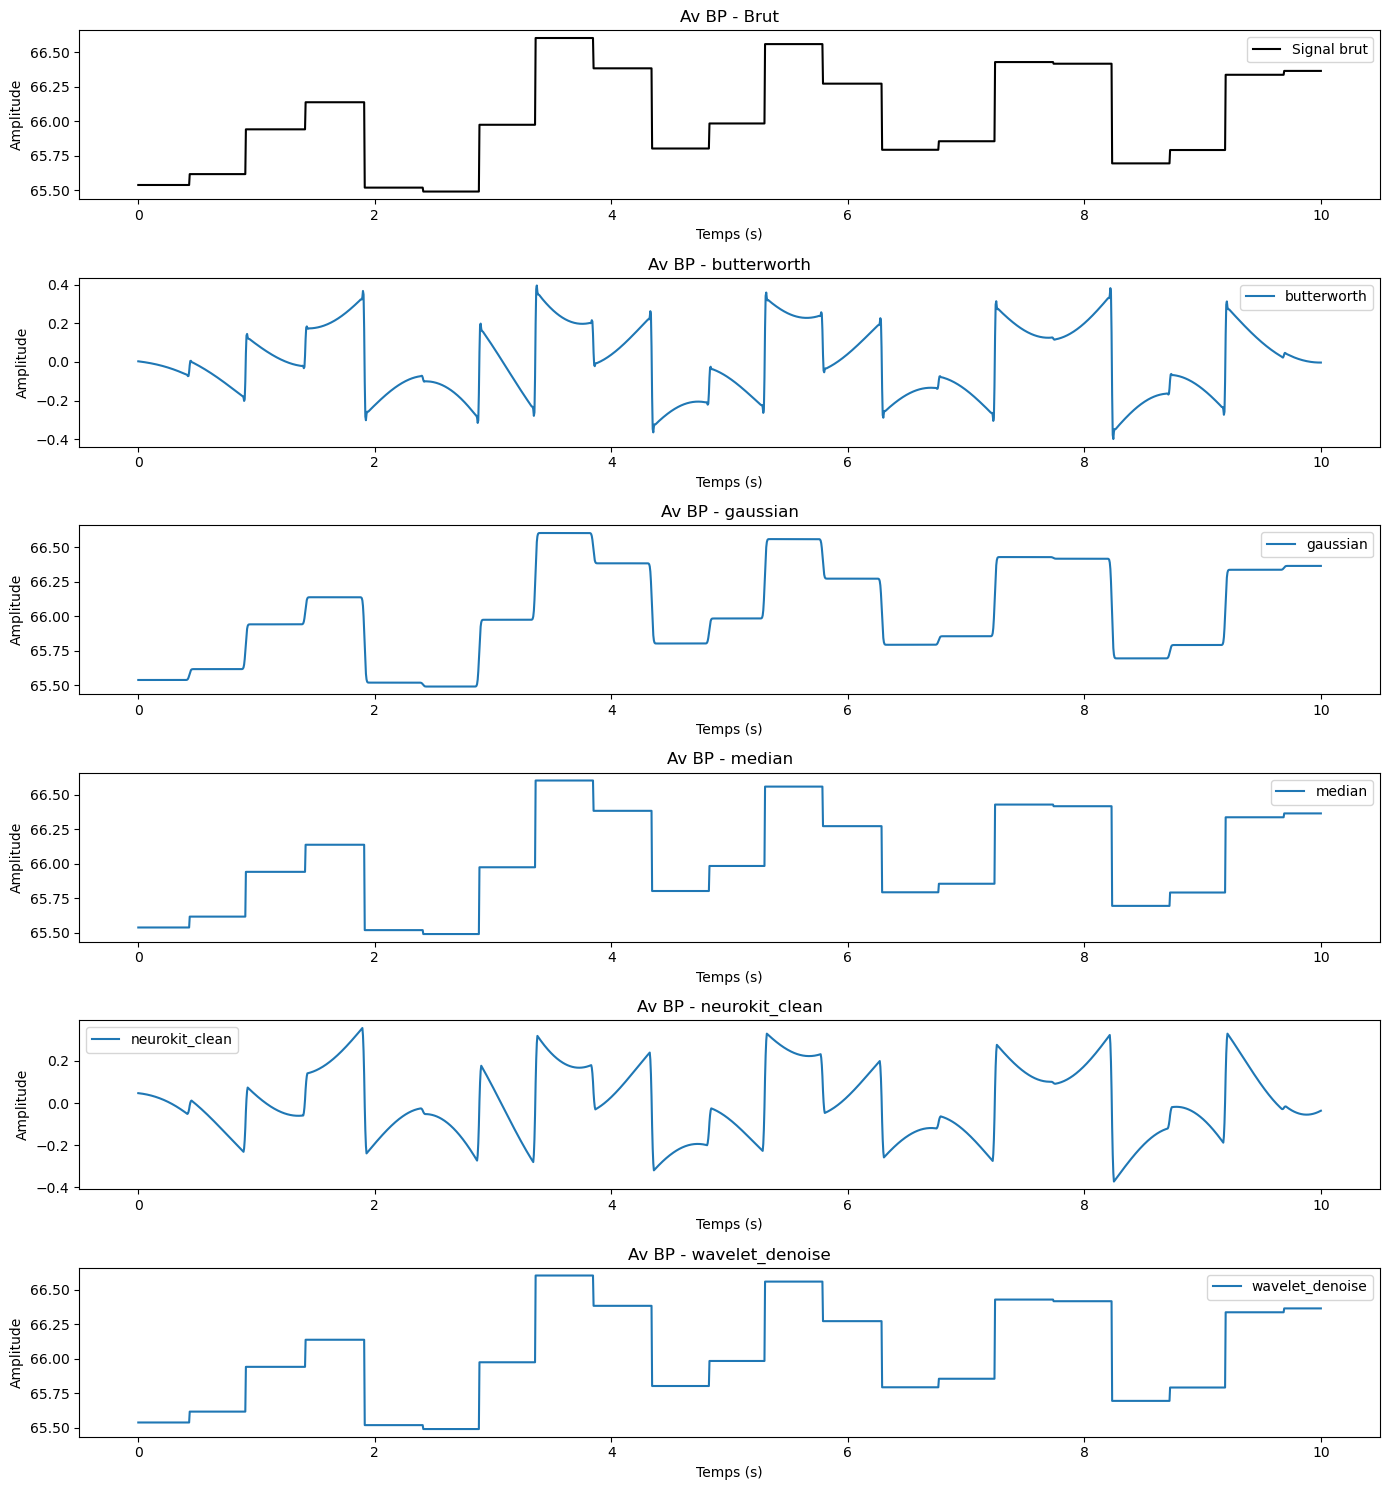


🔍 Traitement du signal : HR


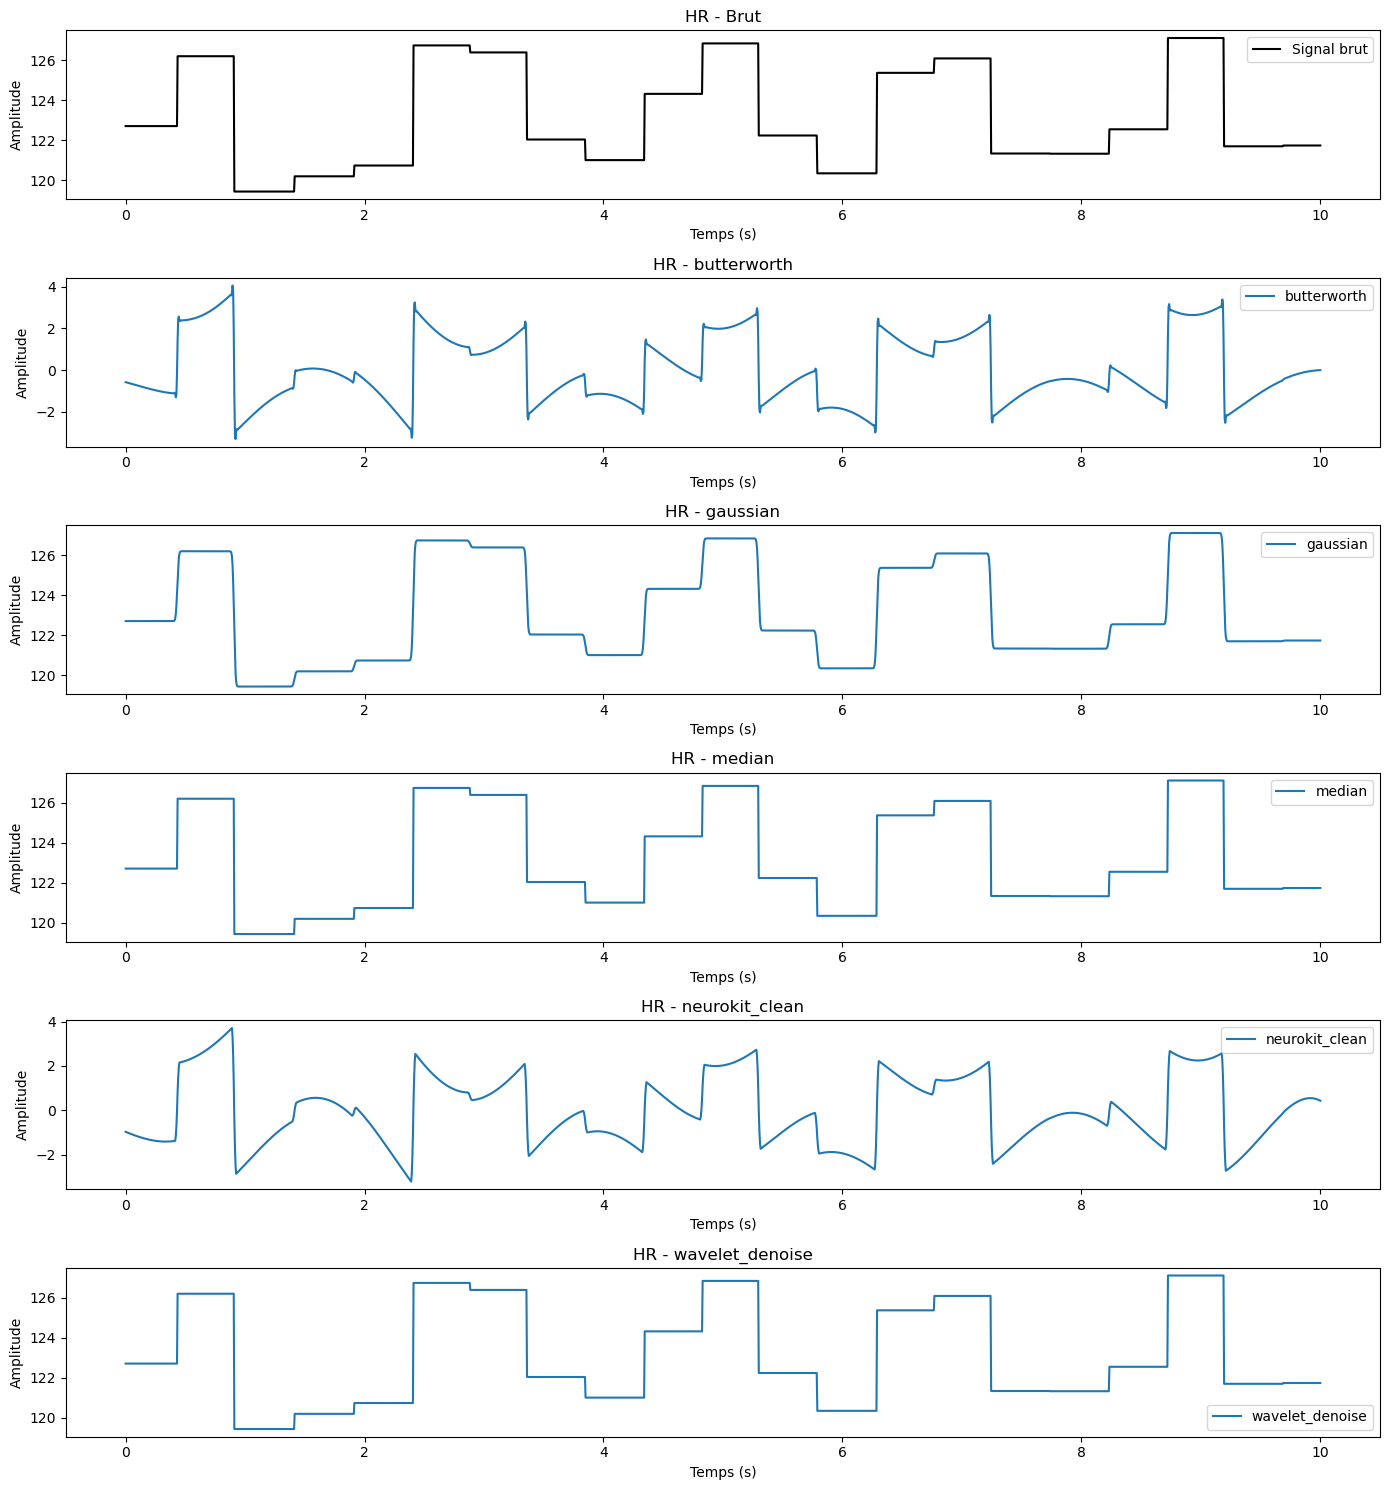


🔍 Traitement du signal : D


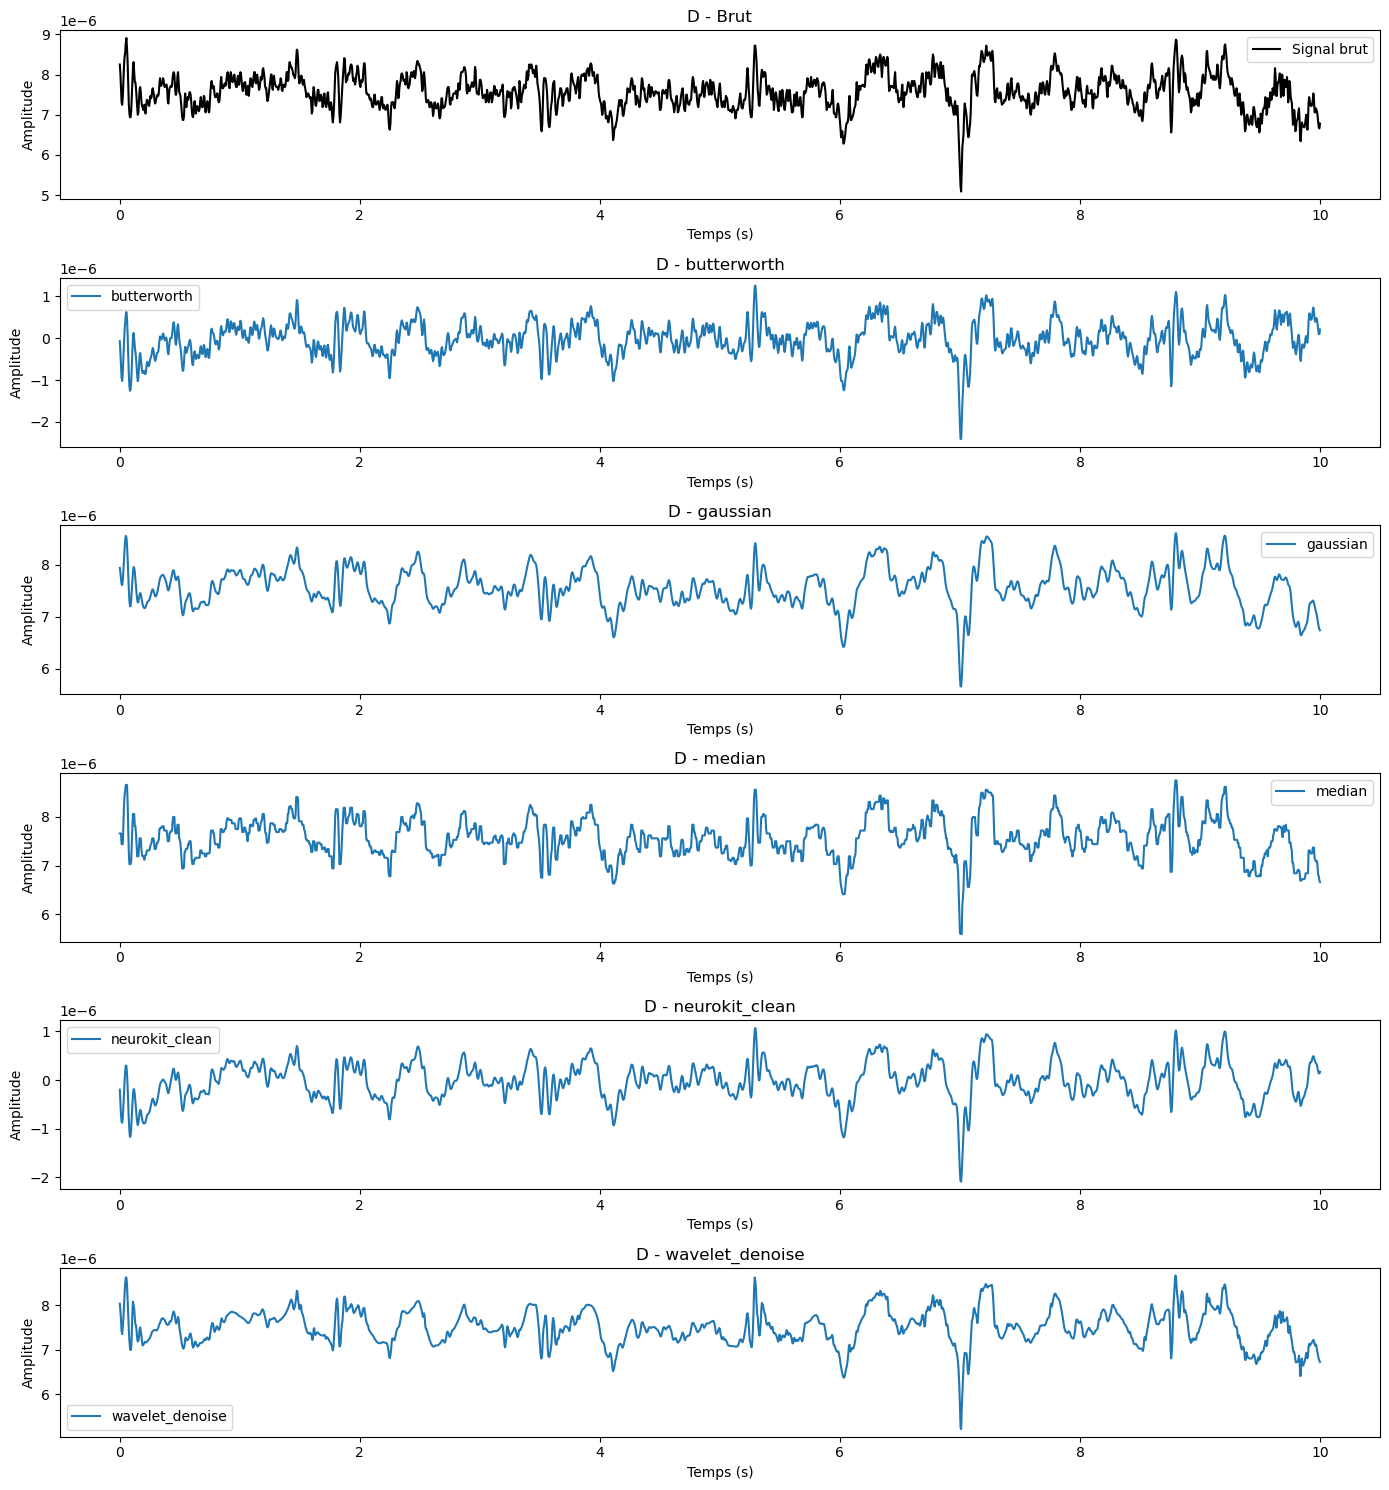


🔍 Traitement du signal : HR2


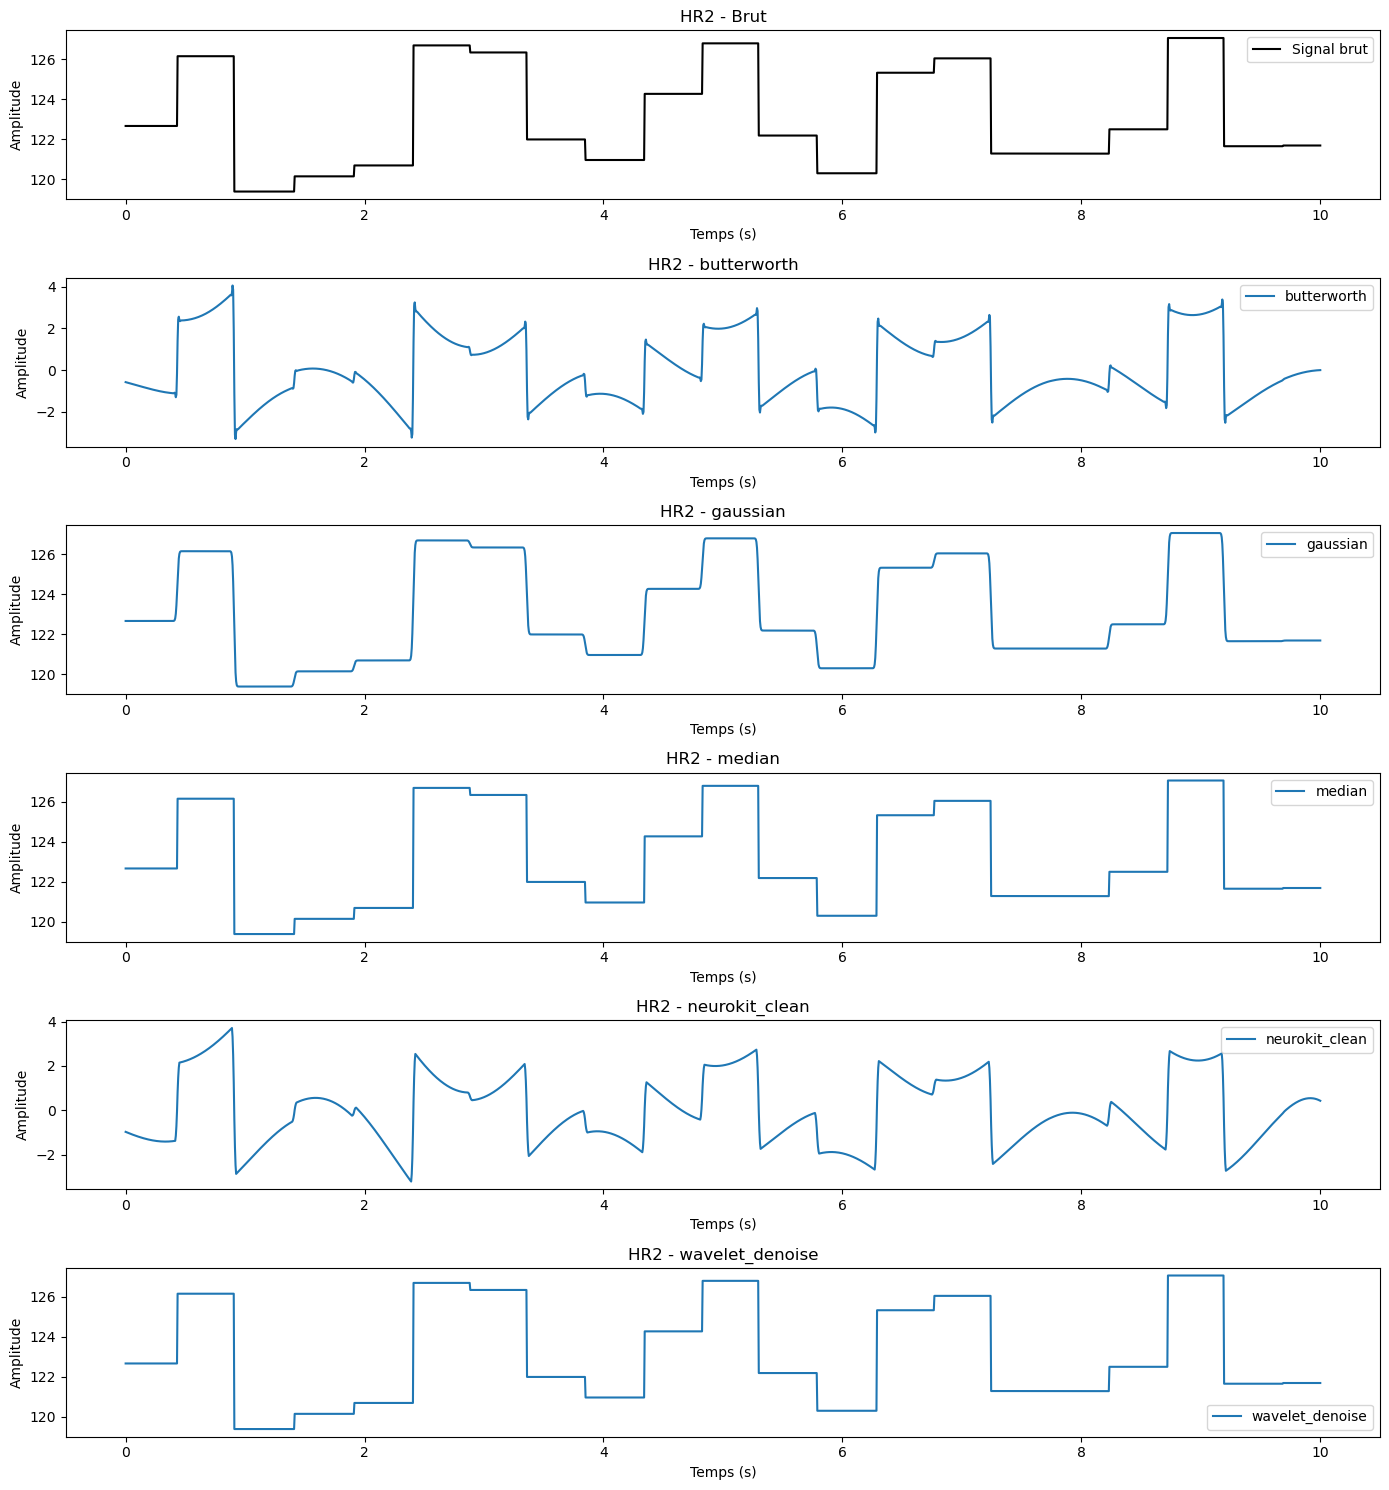

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp
import pywt
import neurokit2 as nk
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

# ----------- CHARGEMENT DES DONNÉES -----------

import pandas as pd
import numpy as np

def load_ecg_data(filepath, start_time=None, end_time=None, interval_ms=5):
    """
    Charge les données ECG depuis un fichier texte tabulé.
    Reconstruit la colonne 'Time' en supposant un intervalle fixe entre les points.
    """
    try:
        df = pd.read_csv(filepath, sep='\t', header=None, encoding='ISO-8859-1', engine='python')
        df.columns = ["Time", "BP", "Av BP", "HR", "D", "HR2", "Comment", "Extra"][:df.shape[1]]
        
        # Remplacer les virgules par des points et convertir les colonnes numériques
        for col in ["BP", "Av BP", "HR", "D", "HR2"]:
            if col in df.columns:
                df[col] = df[col].astype(str).str.replace(',', '.', regex=True).astype(float)

        # Supprimer les colonnes inutiles
        df.drop(columns=[col for col in ["Comment", "Extra"] if col in df.columns], inplace=True)

        # Supprimer les lignes incomplètes
        df.dropna(inplace=True)

        # Recalculer Time
        sampling_interval = interval_ms / 1000  # en secondes
        df["Time"] = np.arange(len(df)) * sampling_interval
        print("🔁 Colonne 'Time' reconstruite (intervalle de 5ms entre chaque point).")

        # Afficher les bornes de temps disponibles
        min_time, max_time = df["Time"].min(), df["Time"].max()
        print(f"📌 Temps disponible : {min_time:.2f}s à {max_time:.2f}s")

        # Filtrer si un intervalle est spécifié
        if start_time is not None and end_time is not None:
            df = df[(df["Time"] >= start_time) & (df["Time"] <= end_time)]
            print(f"✅ Données chargées entre {start_time}s et {end_time}s")

        return df

    except Exception as e:
        print(f"❌ Erreur lors du chargement : {e}")
        return None


# ----------- MÉTHODES DE TRAITEMENT -----------

def filter_signal(signal, sampling_rate=200):
    filters = {}

    # 1. Filtrage Butterworth (0.5-45 Hz)
    try:
        nyq = 0.5 * sampling_rate
        b, a = sp.butter(2, [0.5/nyq, 45/nyq], btype='band')
        filters['butterworth'] = sp.filtfilt(b, a, signal)
    except:
        filters['butterworth'] = None

    # 2. Gaussian Filter (sigma=2)
    filters['gaussian'] = gaussian_filter1d(signal, sigma=2)

    # 3. Median Filter (fenêtre = 5)
    filters['median'] = medfilt(signal, kernel_size=5)

    # 4. NeuroKit2 - Clean ECG
    try:
        filters['neurokit_clean'] = nk.ecg_clean(signal, sampling_rate=sampling_rate, method="neurokit")
    except:
        filters['neurokit_clean'] = None

    # 5. Wavelet Denoising (Daubechies)
    try:
        coeffs = pywt.wavedec(signal, 'db4', level=4)
        threshold = np.median(np.abs(coeffs[-1])) / 0.6745 * np.sqrt(2 * np.log(len(signal)))
        coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
        filters['wavelet_denoise'] = pywt.waverec(coeffs, 'db4')
    except:
        filters['wavelet_denoise'] = None

    return filters

# ----------- AFFICHAGE DES SIGNAUX -----------

def plot_signals(raw_signals, filtered_signals_dict, time, column_name):
    fig, axs = plt.subplots(len(filtered_signals_dict) + 1, 1, figsize=(14, 2.5 * (len(filtered_signals_dict) + 1)))

    # Signal brut
    axs[0].plot(time, raw_signals, label="Signal brut", color='black')
    axs[0].set_title(f"{column_name} - Brut")
    axs[0].legend()

    # Signaux filtrés
    for i, (name, signal) in enumerate(filtered_signals_dict.items(), start=1):
        if signal is not None:
            signal = signal[:len(time)]  # découpage si nécessaire
            axs[i].plot(time, signal, label=name)
            axs[i].set_title(f"{column_name} - {name}")
            axs[i].legend()

    for ax in axs:
        ax.set_xlabel("Temps (s)")
        ax.set_ylabel("Amplitude")

    plt.tight_layout()
    plt.show()


# ----------- MAIN -----------

if __name__ == "__main__":
    filepath = "../data/data1/Sansinjection.txt"  # <-- À adapter si besoin
    start_time, end_time = 0, 10
    sampling_rate = 200  # 1 point toutes les 5 ms

    df = load_ecg_data(filepath, start_time, end_time)

    if df is not None:
        time = df["Time"].values

        # Pour chaque colonne physiologique, on traite et affiche
        for col in df.columns:
            if col == "Time":
                continue

            raw = df[col].values
            print(f"\n🔍 Traitement du signal : {col}")
            filtered = filter_signal(raw, sampling_rate=sampling_rate)

            # Ajustement taille si nécessaire
            for k in filtered:
                if filtered[k] is not None and len(filtered[k]) != len(time):
                    filtered[k] = filtered[k][:len(time)]

            plot_signals(raw, filtered, time, col)
